<a href="https://colab.research.google.com/github/dmytro-varich/Texture-Segmentation-App/blob/main/segmentation_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Jacob Gildenblat, 2015
#Implementation of edge preserving smoothing by minimizing with the Ambrosio-Tortorelli appoach
#AM scheme, using conjugate gradients
import cv2, scipy
import numpy as np
import sys
import scipy
from scipy.sparse.linalg import LinearOperator

class AmbrosioTortorelliMinimizer():
	def __init__(self, img, iterations = 1, solver_maxiterations = 10, tol = 0.1, alpha = 1000, beta = 0.01, epsilon = 0.01):
		self.iterations = iterations
		self.tol = tol
		self.g = np.float64(img) / np.max(img)
		self.f = self.g
		self.edges = np.zeros(img.shape)
		self.update_gradients()
		self.alpha, self.beta, self.epsilon = alpha, beta, epsilon
		self.add_const = self.beta / (4 * self.epsilon)
		self.multiply_const = self.epsilon * self.beta
		self.maxiter = solver_maxiterations

	def update_gradients(self):
		self.grad_x, self.grad_y = self.gradients(self.f)
		self.gradient_mag = np.power(self.grad_x, 2) + np.power(self.grad_y, 2)

	def edge_linear_operator(self, input):
		v = input.reshape(*self.g.shape)
		result = np.multiply(v, self.gradient_mag * self.alpha + self.add_const) \
				- self.multiply_const* cv2.Laplacian(v, cv2.CV_64F)

		return result.reshape(*input.shape)

	def image_linear_operator(self, input):
		f = input.reshape(*self.g.shape)

		x, y = self.gradients(f)

		result = f - 2*self.alpha * (self.calc_grad_x(np.multiply(self.edges, x)) + self.calc_grad_y(np.multiply(self.edges, y)) )
		return result.reshape(*input.shape)

	def solve_edges(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.edge_linear_operator, dtype = np.float64)
		b = np.ones(size) * self.beta / (4 * self.epsilon)

		self.edges, _ = scipy.sparse.linalg.cg(A, b, rtol = self.tol, maxiter = self.maxiter)
		self.edges = np.power(self.edges.reshape(*self.g.shape), 2)
		return self.edges

	def solve_image(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.image_linear_operator, dtype = np.float64)
		b = self.g.reshape(size)

		self.f, _ = scipy.sparse.linalg.cg(A, b, rtol = self.tol, maxiter = self.maxiter)
		self.f = self.f.reshape(*self.g.shape)
		self.update_gradients()
		return self.f

	def minimize(self):
		for i in range(0, self.iterations):
			self.solve_edges()
			self.solve_image()

		self.edges = np.power(self.edges, 0.5)
		cv2.normalize(self.f, self.f ,0,255,cv2.NORM_MINMAX)
		cv2.normalize(self.edges, self.edges ,0,255,cv2.NORM_MINMAX)
		self.f = np.uint8(self.f)
		self.edges = 255 - np.uint8(self.edges)

		return self.f, self.edges

	def calc_grad_x(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]))

	def calc_grad_y(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]).T)

	def gradients(self, img):
		return self.calc_grad_x(img), self.calc_grad_y(img)

In [2]:
!pip install -U cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-lcimu318
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-lcimu318
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405168 sha256=bd438693b65aa5ff6e5f2db86760d7ddbc55199c447f616317d334e7c3b9db3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-jd8zr9qm/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf


In [72]:
# Standard libraries
import os
from typing import Union, Dict, Tuple, List, Any, Optional

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2

# skimage libraries
from skimage import io, transform
from skimage.filters.rank import entropy
from skimage.filters import gaussian

# scipy libraries
from scipy.ndimage import gaussian_filter

# sklearn libraries
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

# pydensecrf library
import pydensecrf.densecrf as dcrf

In [70]:
class TextureSegmentation:
    """"""
    @staticmethod
    def load_images(directory: str) -> Dict[str: np.ndarray]:
        """
        Loads all images from the specified directory and returns them as a dictionary.

        Args:
            directory (str): The path to the directory containing images.

        Returns:
            dict: A dictionary where keys are filenames and values are images.
        """
        images = dict()
        # Ensure the provided directory is valid
        if not os.path.isdir(directory):
            raise ValueError(f"The specified directory {directory} does not exist or is not a valid directory.")

        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            # Check if the file is indeed an image
            if os.path.isfile(file_path):
                try:
                    image = io.imread(file_path)
                    images[filename] = image
                except Exception as e:
                    print(f"Failed to read {filename}: {e}")

        return images

    @staticmethod
    def show_images(images: Dict[str: np.ndarray], *, rows: int, cols: int, figsize: Tuple[int, int] = (15, 10), cmap: str = None, show_ax: str = 'on') -> None:
        """
        Displays a grid of images with titles on a subplot grid.

        Args:
            images (dict): A dictionary where keys are image titles and values are the images themselves.
            rows (int): Number of rows in the subplot grid.
            cols (int): Number of columns in the subplot grid.
            figsize (tuple): The size of the entire figure (width, height). Default is (15, 10).
            cmap (str): Colormap to be used for the images (optional).
            show_ax (str): Whether to display axis ('on' or 'off'). Default is 'on'.

        Returns:
            None
        """
        # Create a subplot grid with the specified number of rows and columns
        fig, axes = plt.subplots(rows, cols, figsize=figsize)

        # If there is only one axis (for example, when rows=1 and cols=1)
        if rows == 1 and cols == 1:
            axes = [axes]
        else:
          axes = axes.flatten()  # Flattening the axes to 1D array

        # Iterate over the axes and images to display them
        for ax, (title, image) in zip(axes, images.items()):
            # Create a copy of the image for normalization
            img = image * 1
            # Normalize the image to the range [0, 255]
            cv2.normalize(img, img,0,255,cv2.NORM_MINMAX)
            # Convert the image to uint8 format for display
            img = np.uint8(img)
            # Display the image
            ax.imshow(img, cmap=cmap)
            # Set the title of the image
            ax.set_title(title)
            # Hide or show axes depending on 'show_ax' argument
            ax.axis(show_ax)

        # Adjust layout to make the plot elements fit neatly
        plt.tight_layout()

        # Display the plot
        try:
            plt.show()
        except KeyboardInterrupt:
            pass

    @staticmethod
    def preprocess_image(image: np.ndarray, *, resize_shape: Tuple[int, int] = None, normalize: bool = True, sigma: Union[None, float, int] = None) -> np.ndarray:
        """

        """
        if not isinstance(image, np.ndarray):
            raise ValueError("Input must be a NumPy array")

        # Resize the image if resize_shape is provided
        if resize_shape is not None:
            image = transform.resize(image, resize_shape, anti_aliasing=True)

        # Normalize image if required
        if normalize:
            image = image.astype(np.float32) / 255.0

        # Apply Gaussian blur if sigma is provided (None means no blur)
        if sigma is not None:
            blurred = gaussian(image, sigma=7)
            image = np.abs(image - blurred)

        return image

    @staticmethod
    def extract_patches(image: np.ndarray, patch_size: Union[int, Tuple[int, int]] = (7, 7)) -> np.ndarray:
        """
        Extracts patches from the input image using a specified patch size.

        Parameters:
        -----------
        image : np.ndarray
            The input image from which patches will be extracted. It must be in the form of a NumPy array.

        patch_size : int or tuple of int, optional, default (7, 7)
            The size of the patches to be extracted.
            - If an integer is provided, the patch size will be (patch_size, patch_size).
            - If a tuple (height, width) is provided, those will be the patch dimensions.

        Returns:
        --------
        np.ndarray
            A NumPy array containing the extracted patches.

        Raises:
        -------
        ValueError
            If patch_size is not an integer or a tuple of length 2.

        RuntimeError
            If there is an error during the patch extraction process.
        """
        # Extract patches
        try:
            # If patch_size is an integer
            if isinstance(patch_size, int):
                patches: np.ndarray = extract_patches_2d(image, patch_size=(patch_size, patch_size))
            # If patch_size is a tuple
            elif isinstance(patch_size, tuple) and len(patch_size) == 2:
                patches: np.ndarray = extract_patches_2d(image, patch_size=patch_size)
            else:
                raise ValueError("patch_size must be an int or a tuple of length 2")
        except Exception as e:
            raise RuntimeError(f"Error extracting patches: {e}")

        return patches

    @staticmethod
    def find_optimal_clusters(data: np.ndarray, max_clusters: int = 50) -> int:
        """
        Finds the optimal number of clusters for the input data using MiniBatchKMeans
        and the silhouette score to evaluate clustering quality.

        Parameters:
        -----------
        data : np.ndarray
            The input data to cluster. It should be in the form of a NumPy array.

        max_clusters : int, optional, default 50
            The maximum number of clusters to test. The method will test all values from 2 up to `max_clusters`.

        Returns:
        --------
        int
            The number of clusters that provides the best silhouette score.
        """
        # Initialize variables to track the best clustering configuration
        best_n = 0
        best_score = -1
        scores = []  # List to store silhouette scores for each number of clusters

        # Iterate over possible numbers of clusters
        for n_clusters in range(2, max_clusters + 1):
            # Perform clustering using MiniBatchKMeans
            kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
            labels = kmeans.fit_predict(data)
            try:
                # Calculate silhouette score to evaluate clustering quality
                score = silhouette_score(data, labels)
            except Exception as e:
                print(f"Error calculating silhouette score for {n_clusters} clusters: {e}")
                continue

            # Store the silhouette score for this number of clusters
            scores.append(score)

            # If the current score is better than the previous best, update the best score and number of clusters
            if score > best_score:
                best_score = score
                best_n = n_clusters

        return best_n

    @staticmethod
    def cluster_patches(patches: Dict[str: np.ndarray], max_clusters: int = 50, *, use_pca: bool = False, find_optimal_clusters: bool = False) -> np.ndarray:
        """
        Cluster image patches using K-Means clustering with optional PCA dimensionality reduction and optimal cluster search.

        Parameters:
        -----------
        patches : Dict[str, np.ndarray]
            A dictionary where keys are image identifiers and values are patch arrays.

        max_clusters : int, optional, default 50
            The maximum number of clusters to test for the optimal clustering. Used if `find_optimal_clusters` is True.

        use_pca : bool, optional, default True
            If True, applies PCA for dimensionality reduction before clustering. If False, skips PCA.

        find_optimal_clusters : bool, optional, default True
            If True, finds the optimal number of clusters using silhouette score. If False, uses `max_clusters` as the number of clusters.

        Returns:
        --------
        np.ndarray
            The centroids of the clusters (PRP).
        """
        # Combine all patches from the images into a single array
        all_patches = []
        for patch_list in patches.values():
            reshaped_patches = patch_list.reshape(patch_list.shape[0], -1)  # Flatten patches (Vectorize)
            all_patches.append(reshaped_patches)
        all_patches = np.vstack(all_patches)  # Stack all patches into a single matrix

        # Apply PCA for dimensionality reduction if enabled
        if use_pca:
            pca = PCA(n_components=20)
            reduced_patches = pca.fit_transform(all_patches)
        else:
            reduced_patches = all_patches

        # Determine the optimal number of clusters if enabled
        if find_optimal_clusters:
            optimal_clusters = TextureSegmentation.find_optimal_clusters(reduced_patches, max_clusters)
            print(f"Optimal number of clusters: {optimal_clusters}")
        else:
             optimal_clusters = max_clusters

        # Perform K-Means clustering
        kmeans = MiniBatchKMeans(n_clusters=optimal_clusters, random_state=42)
        kmeans.fit(reduced_patches)

        # Cluster centroids = PRP (Principal Representative Patterns)
        cluster_centroids: np.ndarray = kmeans.cluster_centers_

        return cluster_centroids

    @staticmethod
    def gaussian_similarity(patch, prp, sigma=0.1, n=False):
        distance = np.linalg.norm(patch - prp)  # Евклидово расстояние
        similarity = np.exp(- (distance ** 2) / (2 * sigma ** 2))  # Функция Гаусса
        if n: print(f"Patch: {patch}, PRP: {prp}, Distance: {distance}, Similarity: {similarity}")
        return similarity

    @staticmethod
    def compute_texture_features(image, prp_centroids, patch_size=(7, 7), sigma=0.1):
        height, width = image.shape
        texture_features = np.zeros((height, width))  # Массив для хранения признаков

        # print(f"PRP Centroids shape: {np.array(prp_centroids).shape}")
        # print(f"First PRP centroid: {prp_centroids[0]}")

        # Разбиение изображения на патчи
        for i in range(height - patch_size[0] + 1):
            for j in range(width - patch_size[1] + 1):
                # Выделение патча
                patch = image[i:i+patch_size[0], j:j+patch_size[1]]
                # print(f"Patch at ({i}, {j}): {patch}")
                # Преобразуем патч в вектор
                patch_vector = patch.flatten()

                # Вычисление сходства с каждым PRP
                similarities = [TextureSegmentation.gaussian_similarity(patch_vector, prp.flatten(), sigma) for prp in prp_centroids]
                # print(f"Similarities: {similarities}")
                # Признак T(i) - максимальное сходство
                texture_features[i + patch_size[0] // 2, j + patch_size[1] // 2] = np.sum(similarities)
        # print(texture_features)

        return texture_features

    @staticmethod
    def segmentation(image, prp_centroids, patch_size=(7, 7), sigma=1, iterations=5):
        # 1. Построение карты текстурных признаков
        texture_map = TextureSegmentation.compute_texture_features(image, prp_centroids, patch_size, sigma)

        img = texture_map * 1
        cv2.normalize(img, img,0,255,cv2.NORM_MINMAX)
        img = np.uint8(img)
        plt.imshow(img, cmap='jet')
        plt.show()

        # print("Texture Features Statistics:")
        # print(f"Min value: {np.min(texture_map)}")
        # print(f"Max value: {np.max(texture_map)}")
        # print(f"Mean value: {np.mean(texture_map)}")
        # print(f"All zeros: {np.all(texture_map == 0)}")
        # 2. Применение функционала Мамфорда-Шаха
        solver = AmbrosioTortorelliMinimizer(texture_map, iterations=iterations)
        segmented_image, edges = solver.minimize()

        labels = np.zeros_like(segmented_image)
        height, width = segmented_image.shape
        # print(segmented_image)
        segmented_image  = segmented_image.astype(np.float32) / 255.0
        for i in range(height - patch_size[0] + 1):
            for j in range(width - patch_size[1] + 1):
              patch = segmented_image[i:i+patch_size[0], j:j+patch_size[1]]
              patch_vector = patch.flatten()
              # print(f"Patch at ({i}, {j}): {patch}")
              similarities = [TextureSegmentation.gaussian_similarity(patch_vector, prp.flatten(), sigma, False) for prp in prp_centroids]
              labels[i + patch_size[0] // 2, j + patch_size[1] // 2] = np.argmax(similarities)
              # print(f"Similarities: {similarities}")
        # print(labels.dtype)
        return segmented_image, edges, labels

    @staticmethod
    def postprocess_segmentation(image, segmented_image, ) -> dict:

        pass

    @staticmethod
    def save_segmented_images(directory: str, segmented_images: dict, tag: str = 'seg') -> None:
        os.makedirs(directory, exit_ok=True)

        for filename, image in segmented_images.items():
            filename = filename.replace('tg', tag)
            file_path = os.path.join(directory, filename)
            imageio.imwrite(file_path, image)


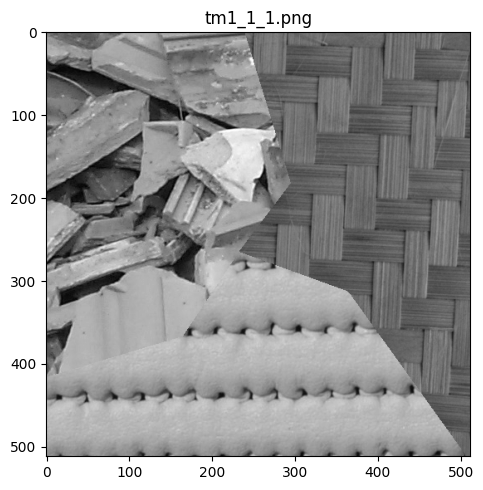

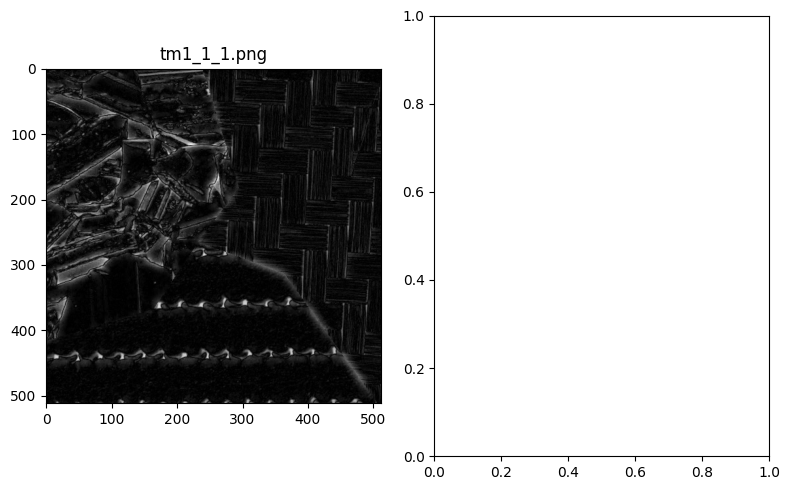

In [71]:
def main(directory):
    # Load images from the specified directory
    images: dict = TextureSegmentation.load_images(directory)

    # Display the images
    rows, cols, figsize = 1, 1, (8, 6)
    TextureSegmentation.show_images(images, rows=rows, cols=cols, figsize=figsize, cmap='gray')

    # Preprocess images
    resize_shape = (256, 256)
    normalize = True
    sigma = 0.3
    for key, image in images.items():
        images[key] = TextureSegmentation.preprocess_image(image, resize_shape=resize_shape, normalize=normalize, sigma=sigma)

    # Display the preprocessed images
    TextureSegmentation.show_images(images, rows=rows, cols=cols, figsize=figsize, cmap='gray')

    # Extract patches from the preprocessed images
    patches = dict()
    patch_size = (7, 7)
    for key, image in images.items():
        patches[key] = TextureSegmentation.extract_patches(image, patch_size=patch_size)

    # print(images)
    # print(patches)

    # Cluster patches to find PRP (Principal Representative Patterns)
    max_clusters = 3
    prp_centroids = TextureSegmentation.cluster_patches(patches, max_clusters=max_clusters, use_pca=False, find_optimal_clusters=False)
    # print(prp_centroids)

    # sigma = 0.3
    # segmented_images, edges, labels = dict(), dict(), dict()
    # iterations = 1
    # for key, image in images.items():
    #     segmented_images[key], edges[key], labels[key] = TextureSegmentation.segmentation(image, prp_centroids,
    #                                                                          patch_size, sigma, iterations)

    # TextureSegmentation.show_images(segmented_images, figsize=figsize, rows=rows, cols=cols, cmap=None)
    # TextureSegmentation.show_images(edges, figsize=figsize, rows=rows, cols=cols, cmap=None)
    # # print(labels['tm1_1_1.png'])
    # TextureSegmentation.show_images(labels, figsize=figsize, rows=rows, cols=cols, cmap='tab20')


#     # TextureSegmantation.save_segmented_images('output', {})


if __name__ == '__main__':
    directory = 'data/'
    main(directory)